In [ ]:
import torch
import sys
import torch
import os.path as osp
import os
import tqdm
import sys
import numpy as np
from tqdm import tqdm

sys.path.append("/eos/home-g/gkrzmanc/mlpf_local")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
import dgl  # CPU only version for now


In [5]:
# This block is the same as 1_dataset

dataset = "/eos/home-g/gkrzmanc/ClicDet_v1/out.root" # Full dataset, merged in 1 ROOT file (https://cernbox.cern.ch/s/TkMHJO5igBCixOs)


class Args:
    def __init__(self):
        self.data_train = [dataset]
        self.data_val = [dataset]
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_local/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [6]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)
g, y = next(iterator)
y.shape


=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


torch.Size([2, 5])

In [7]:
g

Graph(num_nodes=299, num_edges=2093,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'pos_hits': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_norm': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(4,), dtype=torch.int64), 'p_hits': Scheme(shape=(1,), dtype=torch.float32), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [8]:
part_idx = g.ndata["particle_number"]

# if part_idx contains -1:
#if torch.sum(part_idx==-1) > 0:
#    true_idx = np.where(part_idx!=-1)[0]
#    print("has -1")#, part_idx, true_idx)
#else:
#    true_idx = np.arange(len(part_idx))
#    part_idx -= 1
true_idx = np.arange(len(part_idx))
part_idx = part_idx[true_idx]
hit_types = g.ndata["hit_type"][true_idx]

hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
hit_energies = g.ndata["e_hits"].flatten()[true_idx]#[hit_idx]
hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
#print(hit_energies.shape, hit_momenta.shape)
#assert hit_momenta.shape[0] + hit_energies.shape[0] == hit_types.shape[0]

In [9]:
part_idx

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [10]:
from torch_scatter import scatter_sum

In [11]:
energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
energy_from_showers

tensor([ 2.2272, 10.7947])

In [12]:
y_momentum = torch.sqrt(y[:, 0]**2 + y[:, 1]**2 + y[:, 2]**2)
y_mass = y[:, 3]

In [13]:
energy_from_showers / y_momentum

tensor([0.7194, 0.8945])

In [14]:
#y_energy = torch.sqrt(y_momentum**2 + y_mass**2)
#y_energy

In [15]:
y_momentum

tensor([ 3.0959, 12.0685])

In [16]:
g.ndata["p_hits"].flatten()[g.ndata["hit_type"][:, 1] == 1]

# hit_types 2 and 3 have energies
# hit_types 0 and 1 have momenta

tensor([])

In [17]:
g.ndata["hit_type"]

tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]])

In [38]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()[true_idx]#[hit_idx]
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    #print(hit_energies.shape, hit_momenta.shape)
    #assert hit_momenta.shape[0] + hit_energies.shape[0] == hit_types.shape[0]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    energy_from_showers
    y_momentum = torch.sqrt(y[:, 0] ** 2 + y[:, 1] ** 2 + y[:, 2] ** 2)
    y_mass = y[:, 3]
    y_pid = y[:, 4].to(torch.long)

    if return_pid_dict:
        pids = y_pid.unique().long()
        y_energy = torch.sqrt(y_momentum ** 2 + y_mass ** 2)
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    if corr_w_mass:
        y_energy = torch.sqrt(y_momentum ** 2 + y_mass ** 2)
        return (energy_from_showers / y_energy).tolist()
    return (energy_from_showers / y_momentum).tolist()



In [19]:
all_ratios = []

for i in tqdm(range(1500)):
    g, y = next(iterator)
    ratios = get_ratios(g, y)
    all_ratios += ratios


  2%|█▉                                                                               | 35/1500 [00:08<05:50,  4.18it/s]


KeyboardInterrupt: 

In [ ]:
all_ratios

In [60]:
y.shape

torch.Size([3, 5])

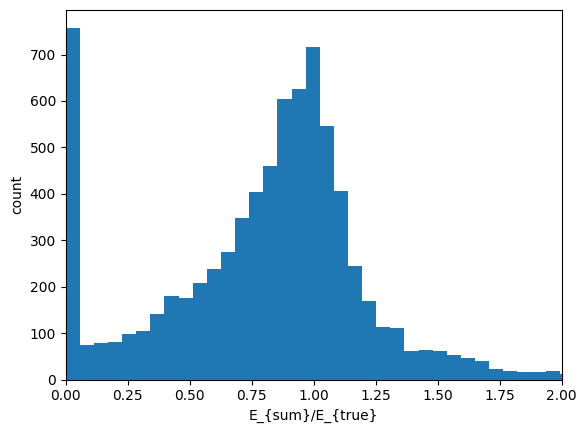

In [65]:
import matplotlib.pyplot as plt
plt.xlim(0, 2)
plt.hist(all_ratios, bins=400)
plt.ylabel("count")
plt.xlabel("E_{sum}/E_{true}")
plt.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/energy_sum_vs_true.pdf")

In [67]:
all_ratios = []

for i in tqdm(range(1500)):
    g, y = next(iterator)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios += ratios


 38%|██████████████████████████████                                                  | 564/1500 [02:21<03:42,  4.20it/s]/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 2, got k = 8, use k = 2
  dgl_warning(
 51%|████████████████████████████████████████▉                                       | 767/1500 [03:33<02:10,  5.61it/s]/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 5, got k = 8, use k = 5
  dgl_warning(
 70%|███████████████████████████████████████████████████████▌                       | 1055/1500 [04:39<01:17,  5.71it/s]/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 6, got k = 8, use k = 6
  dgl_warning(
 89%|███████████

In [69]:
import matplotlib.pyplot as plt
plt.xlim(0, 2)
plt.hist(all_ratios, bins=400)
plt.ylabel("count")
plt.xlabel("E_{sum}/E_{true}")
plt.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/energy_sum_vs_true_corrected_with_mass.pdf")

In [50]:
#all_ratios = {}

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(1500)):
    g, y = next(iterator)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)

  2%|█▊                                                                               | 34/1500 [00:16<11:35,  2.11it/s]/home/gkrzmanc/env/lib/python3.10/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 6, got k = 8, use k = 6
  dgl_warning(
 14%|███████████▌                                                                    | 216/1500 [01:34<03:08,  6.82it/s]

In [52]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 35))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    ax[i].set_xlim(0, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum}/E_{true}$")
    ax[i].set_title(f"{keys[i]}")

fig.tight_layout()
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/PID_filtered_energy_sum_vs_true.pdf")


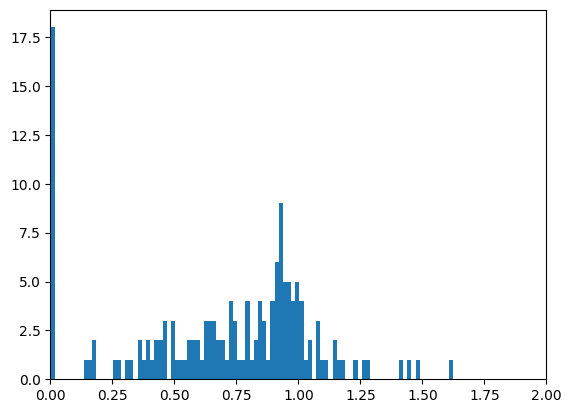

In [42]:
plt.hist(all_ratios["ALL"], bins=400)
plt.xlim(0, 2)
plt.show()

In [46]:
#all_ratios["-13"]

[0.3875284492969513]

In [53]:
import pickle
pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/PID_filtered_energy_sum_vs_true.pkl", "wb"))